In [2]:
from custom_torch_dataset import SwipeDataset
import os
from torch.utils.data import random_split

dataset_path = os.path.join(os.getcwd(), "dataset")

data = SwipeDataset(data_dir=dataset_path,
                    batch=False,)

train_set, val_set, test_set = random_split(data, [0.8, 0.1, 0.1])

In [3]:
import torch
from torch.nn.utils.rnn import pack_sequence, pad_sequence

def collate_fn(batch):
    """
    :param batch: List of tuples (input, word, word_tensor)
                  - input: (T, 6)
                  - word: a string of characters
                  - word_tensor: encoded word as indicies, 0 is SOS, 27 is EOS and 28 is PAD

    """
    # Sort batch by sequence length (descending order)
    batch.sort(key=lambda x: x[0].shape[0], reverse=True)

    inputs, words, targets = zip(*batch)
    en_input = pack_sequence(inputs)   # pack the inputs
    
    de_input = [torch.cat([torch.LongTensor([0]),word]) for word in targets]
    targets = [torch.cat([word,torch.LongTensor([27])]) for word in targets]

    de_input = pad_sequence(de_input, batch_first=True, padding_value=28) # decoder inputs dont require packing as they go in one by one
    targets = pad_sequence(targets, batch_first=True, padding_value=28).view(-1)

    return en_input, de_input.long(), targets.long(), list(words)

In [4]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)

dataloaders = {"train": train_loader,
               "val": val_loader}

In [9]:
pp = next(iter(train_loader))
de_in = pp[1]
target = pp[2]
words = pp[-1]

In [72]:
pp[0]

PackedSequence(data=tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  4.1953e-04,  0.0000e+00,
         -2.0199e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  8.1477e-04,  0.0000e+00,
          3.1416e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        ...,
        [ 2.5246e-01,  6.5306e-01,  5.6170e+03,  8.7468e-04,  1.3016e-05,
         -1.8073e+00],
        [ 2.5246e-01,  6.4626e-01,  5.6340e+03,  4.0016e-04, -2.7913e-05,
         -1.5708e+00],
        [ 2.5246e-01,  6.3946e-01,  5.6500e+03,  4.2517e-04,  1.5631e-06,
         -1.5708e+00]]), batch_sizes=tensor([128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 127, 125, 123, 123,
        123, 123, 123, 119, 119, 117, 117, 115, 115, 115, 115, 115, 113, 111,
        110, 108, 108, 108, 108, 108, 107, 106, 105, 102, 101,  99,  98,  96,
         95,  92,  92,  91,  91,  89,  89,  88,  86,  86,  85,  85,  82,  81,
         80,  78,  76,  76,  75,  75,  74,  72,  70,  67,  

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence
import numpy as np
from tqdm import trange
import random

SOS = 0
EOS = 27
PAD = 28

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, bidirectional = True, dropout = 0.1):
        """
        LSTM in the model is always batch first
        param input_size: input size for encoder, 6
        param hidden_size: hidden_size for LSTM
        param num_layers: number of layers
        param bidirectional: bool
        """
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.dropout = dropout

        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True,
                            bidirectional=bidirectional,
                            dropout = dropout)
        self.ln = nn.LayerNorm(2 * hidden_size if bidirectional else hidden_size)
        # projection for the hidden and cell layers and output
        self.fc_hidden = nn.Linear(2 * hidden_size if bidirectional else hidden_size, hidden_size)
        self.fc_cell = nn.Linear(2 * hidden_size if bidirectional else hidden_size, hidden_size)
        self.fc_out = nn.Linear(2 * hidden_size if bidirectional else hidden_size, hidden_size)

    def forward(self, x):
        """
        : param x: packed sequence
        : return outputs: (seq_len, batch_size, hidden_size)
        : return hidden, cell: the final hidden and cell states
        """
        lstm_outputs, (hidden, cell) = self.lstm(x)
        lstm_outputs = pad_packed_sequence(lstm_outputs, batch_first=True)[0]
        # shape now of states is (2, hidden state) after concat
        hidden_states = torch.cat([torch.cat((hidden[i,:,:], hidden[i+1,:,:]), dim=1).unsqueeze(0) for i in range(0, hidden.shape[0], 2)], dim=0)
        cell_states = torch.cat([torch.cat((cell[i,:,:], cell[i+1,:,:]), dim=1).unsqueeze(0) for i in range(0, cell.shape[0], 2)], dim=0)

        hidden = self.fc_hidden(hidden_states)
        cell = self.fc_cell(cell_states)

        lstm_outputs = self.ln(lstm_outputs)
        outputs = self.fc_out(lstm_outputs)

        return outputs, hidden, cell
class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers=2, bidirectional=False, dropout = 0.1):
        """
        LSTM in the model is always batch first
        param input_size: input size for decoder, should equal 29 also equals output size
        param hidden_size: hidden_size for LSTM
        param num_layers: number of layers
        param bidirectional: bool
        """
        super(Decoder, self).__init__()
        self.outuput_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.dropout = dropout

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(input_size=2*hidden_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True,
                            bidirectional=bidirectional,
                            dropout = dropout)
        self.ln = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size,output_size)

    def forward(self, input, hidden, cell, encoder_output):
        """
        param input: (batch_size) next input, indicies
        param hidden: previous hidden state of decoder  (num_layers, N, hidden_size)
        param cell: previous cell state of decoder  (num_layers, N, hidden_size)
        param encoder_output: encoder output used for attention value and key
        """

        query = hidden[-1].unsqueeze(0).permute(1, 0, 2) # (N, num_layers, hidden_size)
        context = F.scaled_dot_product_attention(query, encoder_output, encoder_output) # (N, 1, hidden size)
        # print(f"context {context.shape}")
        embedded = self.embedding(input.long())    # (N, hidden size)
        # print(f"embedded {embedded.shape}")
        decoder_input = torch.cat((embedded, context), dim = -1)   # (N, 1, hidden + output_size)

        # lstm_out shape (N, 1, hidden_size)
        lstm_out, (hidden, cell) = self.lstm(decoder_input, (hidden, cell))
        lstm_out = self.ln(lstm_out)
        output = F.softmax(self.fc(lstm_out), dim=-1)
        
        # output: (batch_size, 1, hidden_size)
        # hidden, cell: (num_layers, batch_size, hidden_size)
        return output, hidden, cell    

class Seq2Seq(nn.Module):
    def __init__(self, hidden_size, num_layers, input_size=6, output_size=29, max_letters = 17, dropout = 0.1):
        super(Seq2Seq, self).__init__()
        self.input_size = input_size                # number of features for input
        self.output_size = output_size              # output size of decoder, should be 29
        self.encoder_hidden_size = hidden_size      # hidden size of encoder and decoder
        self.num_layers = num_layers                # number of layers for both lstms
        self.max_letters = max_letters              # max length of prediction
        self.dropout = dropout

        self.encoder = Encoder(input_size=input_size,
                               hidden_size=hidden_size,
                               num_layers=num_layers,
                               bidirectional=True,
                               dropout = dropout)

        self.decoder = Decoder(hidden_size=hidden_size,
                               output_size=output_size,
                               num_layers=num_layers,
                               bidirectional=False, # keep decoder unidirectional
                               dropout = dropout) 
    
    def forward(self, encoder_input, target_tensor, force_ratio = 0.5):
        """
        param encoder_input: packed sequence
        param target_tensor: (N, max_word_length) padded word tensors
        param force_ratio: chance for teacher forcing
        """
        batch_size = target_tensor.shape[0]
        target_length = target_tensor.shape[1]
        # where to store all the probabilities
        outputs = torch.zeros(batch_size, target_length, self.output_size).to(next(self.parameters()).device)

        # encode the sequence
        encoder_output, hidden, cell = self.encoder(encoder_input)
        # get the first decoder input
        decoder_input = target_tensor[:, 0].unsqueeze(1) # should be all zeros

        for i in range(target_length):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell, encoder_output)
            # print(f"output{output.shape}")
            outputs[:,i,:] = output.squeeze(1)

            if i < target_length - 1:
                teacher_force = torch.rand(1).item() < force_ratio  # probability of being true or false
                if teacher_force:
                    decoder_input = target_tensor[:, i + 1].unsqueeze(1)
                else:
                    decoder_input = torch.argmax(output, dim=-1)

        return outputs
    
    def predict(self, input, max_length):
        batch_size = input.shape[0]
        # store outputs
        outputs = torch.zeros(batch_size, max_length, self.output_size).to(next(self.parameters()).device)

        # encode the sequence
        encoder_output, hidden, cell = self.encoder(input)
        # get the first decoder input
        decoder_input = torch.LongTensor([0]*batch_size).to(next(self.parameters()).device).unsqueeze(1)

        for i in range(max_length):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell, encoder_output)
            outputs[:,i,:] = output.squeeze(1)
            decoder_input = torch.argmax(output, dim=-1)

        return outputs

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
t_model = Seq2Seq(hidden_size=64,
                  num_layers=2,
                  input_size=6,
                  output_size=29,
                  max_letters=17).to(device)

In [10]:
t_en_in = pp[0].to(device)
t_de_in = pp[1].to(device)
t_out = t_model(t_en_in,t_de_in)

In [12]:
t_out.view(-1,29).shape

torch.Size([1664, 29])

In [89]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=28)
target = target.to(device)
indx = torch.argmax(t_out, dim = -1)
loss = loss_fn(t_out.view(-1,29), target)

In [6]:
import torch
import time
from tempfile import TemporaryDirectory
import os
import matplotlib.pyplot as plt

class EarlyStopper:
    def __init__(self, patience=15, min_delta=0.05):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.best_validation_loss - self.min_delta:
            self.best_validation_loss = validation_loss
            self.counter = 0
            return False  # No early stopping
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True  # Stop training
            return False

def train(model, dataloaders, set_lengths, optimiser, num_epochs = 5, scheduler = None, patience = 15, min_delta = 0.05):
    criterion = torch.nn.CrossEntropyLoss(ignore_index=28)

    train_loss = []
    val_loss = []

    early_stopper = EarlyStopper(patience=patience, min_delta = min_delta)
    stop = False

    since = time.time()
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        lowest_loss = float("Inf")
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for en_input, de_input, targets, words in dataloaders[phase]:
                    en_input = en_input.to(device)
                    de_input = de_input.to(device)
                    targets = targets.to(device)

                    # zero the parameter gradients
                    optimiser.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(en_input, de_input, force_ratio=0.9)
                        loss = criterion(outputs.view(-1, 29), targets)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
                            loss.backward()
                            optimiser.step()

                    # statistics
                    running_loss += loss.item() * de_input.shape[0] # multiply by batch size
                if phase == 'train' and scheduler is not None:
                    # scheduler.step(loss)
                    scheduler.step()

                epoch_loss = running_loss / set_lengths[phase]

                print(f'{phase} Loss: {epoch_loss:.4f}')
                
                if phase == "train":
                    train_loss.append(epoch_loss)
                else:
                    val_loss.append(epoch_loss)
                
                # early stop based on validation loss
                if phase == 'val':
                    stop = early_stopper.early_stop(epoch_loss)

                # deep copy the model
                if phase == 'val' and epoch_loss < lowest_loss:
                    lowest_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)
                
            if stop:
                break
            
            time_elapsed = time.time() - since
            print(f"Time Elapsed: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Lowest Loss: {lowest_loss:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

        plt.plot(train_loss, label="Training Loss")
        plt.plot(val_loss, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid()
        plt.legend()
        plt.show
    return model

Epoch 1/100
----------
train Loss: 3.1840
val Loss: 3.1417
Time Elapsed: 0m 18s

Epoch 2/100
----------
train Loss: 3.1267
val Loss: 3.1131
Time Elapsed: 0m 36s

Epoch 3/100
----------
train Loss: 3.1049
val Loss: 3.0945
Time Elapsed: 0m 55s

Epoch 4/100
----------
train Loss: 3.0895
val Loss: 3.0846
Time Elapsed: 1m 13s

Epoch 5/100
----------
train Loss: 3.0784
val Loss: 3.0766
Time Elapsed: 1m 31s

Epoch 6/100
----------
train Loss: 3.0687
val Loss: 3.0659
Time Elapsed: 1m 50s

Epoch 7/100
----------
train Loss: 3.0638
val Loss: 3.0539
Time Elapsed: 2m 9s

Epoch 8/100
----------
train Loss: 3.0559
val Loss: 3.0444
Time Elapsed: 2m 28s

Epoch 9/100
----------
train Loss: 3.0461
val Loss: 3.0373
Time Elapsed: 2m 47s

Epoch 10/100
----------
train Loss: 3.0405
val Loss: 3.0380
Time Elapsed: 3m 6s

Epoch 11/100
----------
train Loss: 3.0317
val Loss: 3.0389
Time Elapsed: 3m 25s

Epoch 12/100
----------
train Loss: 3.0325
val Loss: 3.0180
Time Elapsed: 3m 43s

Epoch 13/100
----------
tra

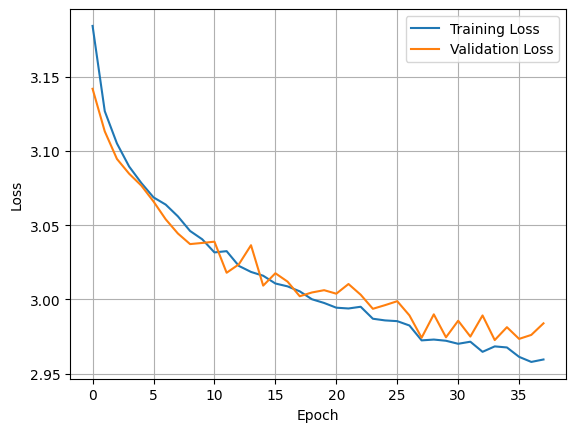

In [7]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
t_model = Seq2Seq(hidden_size=128,
                  num_layers=2,
                  input_size=6,
                  output_size=29,
                  max_letters=17,
                  dropout=0.1).to(device)

set_lengths = {"train":len(train_set),
               "val":len(val_set)}
scheduler = None
optimiser = torch.optim.AdamW(t_model.parameters(), lr=0.005)
# optimiser = torch.optim.SGD(t_model.parameters(), lr=0.2, momentum=0)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, factor=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma = 0.9)
c_model = train(t_model, dataloaders,set_lengths, optimiser, num_epochs=100, scheduler=scheduler, patience = 10, min_delta = 0.01)